<a href="https://colab.research.google.com/github/sehgalsakshi/Content-Based-Recommendation-System/blob/main/Content_Based_Recommendation_(BERT_TFIDF_Word2Vec).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Content Based Recommendation System**

Word embeddings generated using:

*   BERT Vectors/ Can be used for any transformer by changing model name
*   TF-IDF Vectors
*   Word2Vec Vectors
*   Combined Word2Vec and TF-IDF Vectors

Steps for all embeddings are same. It's bit elaborative in the notebook for BERT embeddings for better understanding.

**Read and Preprocess Data**


*   Different preprocessing is required for transformer based models since they require minimal preprocessing.

<br>**Vector Generation**
*   Vectors are generated using classes extending TransformerMixin and BaseEstimator. Since such a class can be added to a column transformer and fit over the particular column of the data.

<br>**Column Transformer**
*   Create a column transformer instance where column/ array is tranformed as per the vector generation class

<br>**Generation word Embeddings**
*   This is just putting above 2 steps into action. Word Embeddings are generated for desired column (sent as numpy array) applying column transformers which in turn returns a list of word embedding for each row. 
We save this as a new column in the dataframe

<br>**Cosine Similarity**
*   Once we've numerical representation of text as per desired word embedding, last step is just to calculate the similarity of two vectors given by the cosine similarity score between the two
*   Also an N x N similarity matrix is constructed which contains similarity score between all N rows of description with each other

<br>**Construction of Recommendation System**
*   Here are just few methods written for giving a list of similar books.
*   As of now books can be recommended using title or description
*   If title is present in the dataframe, it looks for top 5 similar books for as many number of books that have the same title
*   If user inputs description, word embeddings for description are generated on the fly and it's similarity score is compared with all the row vectors (saved in data frame itself) and top 5 books are recommended.
*   There is also a parameter that allows partial filtering by rating. It first finds double the number of books to recommend to user over a certain threshold and then sorts the 2*n books by ratings and returns top n books.
*   Another approach could have been sorting by ratings first and then by score but this might have returned very high rated books but less similarity score.

<br>**Future Scope**
*   Abstractive/ Extractive summarization of longer description
*   Right now absolute title are looked for while recommending, spell checks or slightly different titles won't return any result. This can be made flexible by using fuzzy match with the title (using fuzzy wuzzy or string matching library/ algorithm)
*   More filtering options can be configured. Implicit/ Explicit Filters can be added for author name, genre, rating etc.

# Installing libraries

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [245]:
joblib.dump(cosine_similarity_w2v_tf_idf,'cosine_similarity_w2v_tf_idf.pkl')

['cosine_similarity_w2v_tf_idf.pkl']

# Reading the Data

In [5]:
# Reading the data
df = pd.read_csv("good_reads_data.csv")

In [6]:
df.columns

Index(['Unnamed: 0', 'Desc', 'Unnamed: 0.1', 'author', 'genre', 'image_link',
       'rating', 'title'],
      dtype='object')

In [7]:
df

,Unnamed: 0,Desc,Unnamed: 0.1,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony
...,...,...,...,...,...,...,...,...
2377,2446,"Ralph Roberts, a sus setenta años y tras la mu...",NaN,Stephen King,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,3.82,Insomnia
2378,2447,Murder at the Vicarage marks the debut of Agat...,NaN,Agatha Christie,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Murder at the Vicarage
2379,2448,In 1951 John Wyndham published his novel The D...,NaN,John Wyndham,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,4.02,The Day of the Triffids
2380,2449,This now classic book revealed Flannery O'Conn...,NaN,Flannery O'Connor,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,4.22,A Good Man is Hard to Find and Other Stories


# Text Preprocessing

In [123]:
#Utitlity functions for removing ASCII characters, converting lower case, removing stop words, html and punctuation from description

def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [9]:
df['Desc'] = df['Desc'].astype(str)

Since for bert/ any transformer based, we need minimum text preprocessing and for other embeddings, we need exhaustive preprocessing steps. Hence creating 2 different preprocessed columns


*   cleaned for bert
*   cleaned_2 for tfidf and word2vec



In [10]:
df['cleaned'] = df['Desc'].apply(_removeNonAscii)
df['cleaned_2'] = df['Desc'].apply(_removeNonAscii)
df['cleaned_2'] = df.cleaned.apply(func = make_lower_case)
df['cleaned_2'] = df.cleaned.apply(func = remove_stop_words)
df['cleaned_2'] = df.cleaned.apply(func=remove_punctuation)
df['cleaned'] = df.cleaned.apply(func=remove_html)
df['cleaned_2'] = df.cleaned.apply(func=remove_html)

In [11]:
df.columns

Index(['Unnamed: 0', 'Desc', 'Unnamed: 0.1', 'author', 'genre', 'image_link',
       'rating', 'title', 'cleaned', 'cleaned_2'],
      dtype='object')

In [12]:
df.drop(df.columns[0], axis=1, inplace=True)

## Basic EDA

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Distribution of Desc Length')

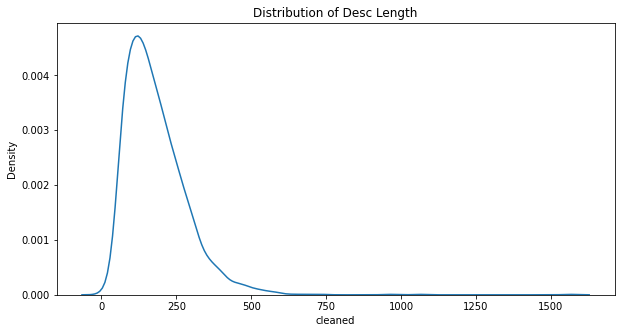

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(df.cleaned.str.split().apply(len))
plt.title("Distribution of Desc Length")

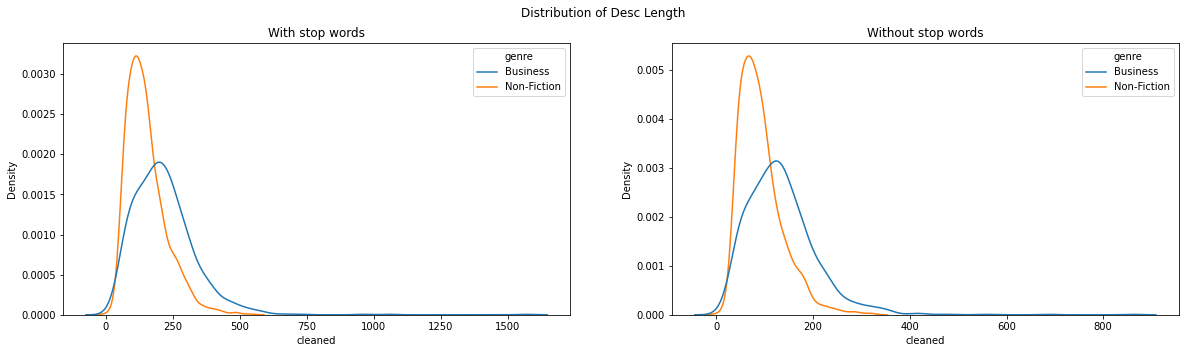

In [20]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
sns.kdeplot(df.cleaned.str.split().apply(len), ax=ax1, hue=df.genre)
ax1.set_title('With stop words')
sns.kdeplot(df.cleaned.apply(func = remove_stop_words).str.split().apply(len), hue=df.genre, ax=ax2)
ax2.set_title('Without stop words')
fig.suptitle("Distribution of Desc Length")
plt.show()

Checking desc length before and after removing stopwords.
<br>Since we are interested in bert embeddings, whose max token length is 512, for text descriptions greater than this length, let's apply stop words removal to generate vectors for most relevant words. 

**Another approach can be to perform further summarization of longer texts using any abstractive/ extractive summarization model**

In [21]:
df['cleaned'] = df.cleaned.apply(lambda x : remove_stop_words(x) if len(x.split())>512 else x)

Text(0.5, 1.0, 'Distribution of Desc Length')

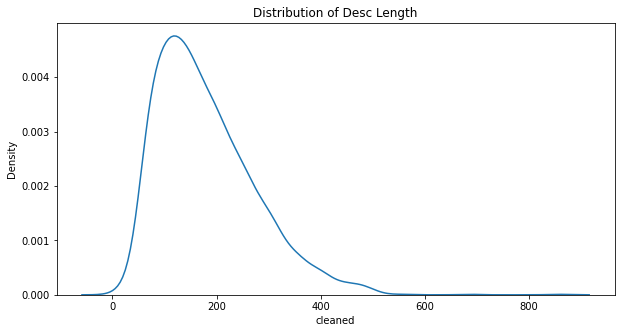

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(df.cleaned.str.split().apply(len))
plt.title("Distribution of Desc Length")

# Bert/ Transformer Vectors Generation

In [124]:
!pip install flair

     |████████████████████████████████| 284 kB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 8.0 MB/s 
     |████████████████████████████████| 19.7 MB 1.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.6 MB 34.2 MB/s 
     |████████████████████████████████| 788 kB 22.9 MB/s 
     |████████████████████████████████| 43 kB 1.3 MB/s 
     |████████████████████████████████| 64 kB 2.5 MB/s 
     |████████████████████████████████| 981 kB 33.4 MB/s 
     |████████████████████████████████| 776.8 MB 12 kB/s 
     |████████████████████████████████| 62 kB 715 kB/s 
     |████████████████████████████████| 3.3 MB 30.7 MB/s 
     |████████████████████████████████| 895 kB 40.5 MB/s 
     |████████████████████████████████| 636 kB 65.8 MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9705 sha256=326edd9ab79a333edfeb738204336adaa6b4d38532db0

In [126]:
import torch
from flair.data import Sentence
from flair.embeddings import TransformerDocumentEmbeddings
from sklearn.base import BaseEstimator, TransformerMixin

In [127]:
class FlairTransformerEmbedding(TransformerMixin, BaseEstimator):

    def __init__(self, model_name='bert-base-uncased', batch_size=None, layers=None):
        # From https://lvngd.com/blog/spacy-word-vectors-as-features-in-scikit-learn/
        # For pickling reason you should not load models in __init__
        self.model_name = model_name
        self.model_kw_args = {'batch_size': batch_size, 'layers': layers}
        self.model_kw_args = {k: v for k, v in self.model_kw_args.items()
                              if v is not None}
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        model = TransformerDocumentEmbeddings(
                self.model_name, fine_tune=False,
                **self.model_kw_args)

        sentences = [Sentence(text) for text in X]
        embedded = model.embed(sentences)
        embedded = [e.get_embedding().reshape(1, -1) for e in embedded]
        return np.array(torch.cat(embedded).cpu())

## Column Transformer

In [56]:
from sklearn.compose import ColumnTransformer
# you may provide any transformer model to get word embeddings from
bert_trans = ColumnTransformer([
    ('embedding', FlairTransformerEmbedding(model_name='bert-base-uncased'), 0) #column name if column given
])


## Building Word Embeddings

In [129]:
def fit_word_embeddings(text_series, column_transformer):
  text_np_array =text_series.array.to_numpy().reshape(-1,1)
  text_vector = column_transformer.fit_transform(text_np_array)
  return text_vector, column_transformer

In [28]:
bert_vectors, bert_embedding_transformer = fit_word_embeddings(df.cleaned, bert_trans)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [132]:
type(bert_vectors), bert_vectors.shape, df.shape

(numpy.ndarray, (2382, 768), (2382, 11))

In [133]:
bert_vectors_list = []
for i in bert_vectors:
  bert_vectors_list.append(i)

#adding bert vectors as column
df['bert_vectors'] = bert_vectors_list

In [30]:
import joblib
joblib.dump(bert_vectors_list, "bert_vectors_list.pkl")
joblib.dump(bert_embedding_transformer, "bert_embedding_transformer.pkl")

['bert_embedding_transformer.pkl']

# Cosine Score Generation

In [134]:
import json
from sklearn.metrics.pairwise import cosine_similarity

In [135]:
#Example usage
cosine_similarity([bert_vectors_list[1]], [bert_vectors_list[0]])

array([[0.8414842]], dtype=float32)

creating a similarity matrix for all book descriptions with each other

In [136]:
cosine_similarity_bert = cosine_similarity(bert_vectors_list, bert_vectors_list)

In [137]:
cosine_similarity_bert.shape

(2382, 2382)

In [216]:
joblib.dump(cosine_similarity_bert, 'cosine_similarity_bert.pkl')

['cosine_similarity_bert.pkl']

# Content-Based Recommendation System Using BERT

These are going to be the common methods for recommending books using any word embeddings. Hence they are parametrized as much as possible.

In [186]:
def get_text_vector(text, column_transformer):
  text_np_array = np.asarray([text])
  text_np_array = text_np_array.reshape(-1,1)
  text_np_array = column_transformer.transform(text_np_array)
  return text_np_array

In [187]:
def find_most_similar_vector_list(input_vector, vector_col):
  cosine_similarity_list = []
  for row in df.itertuples():
    cosine_similarity_value = cosine_similarity(input_vector, [getattr(row, vector_col)])
    cosine_similarity_list.append(cosine_similarity_value[0][0])
  return cosine_similarity_list

In [188]:
def create_book_dict(idx_score):
  books_dict = df.iloc[idx_score[0]].to_dict()
  books_dict['score']=float(idx_score[1])
  books_dict['id']=float(idx_score[0])
  keys_to_retain = ['id','Desc', 'title', 'author', 'genre', 'image_link', 'rating', 'score']
  return dict((key,value) for key, value in books_dict.items() if key in keys_to_retain)

In [228]:
def get_recommendations_list(cosine_list, num_books, idx = None, filter_by_rating=True, thresh_score=.85):
  cosine_list = sorted(enumerate(cosine_list), key=lambda i: i[1], reverse=True)
  if filter_by_rating:
    cosine_thresh_list = cosine_list.copy()
    cosine_thresh_list = [(book, df.iloc[book[0]].to_dict()['rating']) for i, book in enumerate(cosine_thresh_list)\
                          if (book[1]>=thresh_score and len(cosine_thresh_list[:i])<=(2*num_books))\
                          or len(cosine_thresh_list[:i])<=num_books]
    cosine_thresh_list = (sorted(cosine_thresh_list, key=lambda i: i[1], reverse=True))[:num_books+1]
    cosine_list = [book[0] for book in cosine_thresh_list]
  else:
    cosine_list = (sorted(enumerate(cosine_list), key=lambda i: i[1], reverse=True))[:num_books+1]
  cosine_list = [ create_book_dict(idx_score) for idx_score in cosine_list if not idx or int(idx_score[0]) != int(idx)]
  return cosine_list

In [229]:
def recommend_books_from_desc(desc, embedding_transformer, vector_col, num_books=5):
  desc_vector = get_text_vector(desc, embedding_transformer)
  return find_most_similar_vector_list(desc_vector, vector_col)

In [231]:
def recommend_books(embedding_transformer, cosine_similarity_matrix, title=None, desc=None, vector_col='bert_vectors', num_books=5,
                               filter_by_rating=True, thresh_score=.85):
  if title:
    recommended_books = {}
    for count, idx in enumerate(df[df.title.str.lower() == title.lower()].index):
      cosine_list = [i[0] for i in cosine_similarity_matrix[idx].reshape(-1,1)]
      recommended_books[idx] = get_recommendations_list(cosine_list, num_books, idx=idx , filter_by_rating=filter_by_rating, thresh_score=thresh_score)
    return recommended_books
  else:
    cosine_list = recommend_books_from_desc(desc, embedding_transformer, vector_col, num_books=num_books)
    return get_recommendations_list(cosine_list, num_books, filter_by_rating=filter_by_rating, thresh_score=thresh_score)
  

In [232]:
desc= "One is tempted to say 'the only book you'll need on starting a business.' Brilliant! Genius! Choose your superlative-it'll fit.\"-Tom Peters   People starting out in business tend to seek step-by-step formulas or rules, but in reality there are no magic bullets. Rather, says veteran company-builder Norm Brodsky, there's a mentality that helps street- smart entrepreneurs solve problems and pursue opportunities as they arise.  Brodsky shares his hard-earned wisdom every month in Inc. magazine, in the hugely popular \"Street Smarts\" column he cowrites with Bo Burlingham. Now they've adapted their best advice into a comprehensive guide for anyone running a small business."

In [233]:
recommend_books(bert_embedding_transformer, cosine_similarity_bert, desc = desc)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'Desc': '“Pfeffer [blends] academic rigor and practical genius into wonderfully readable text. The leading thinker on the topic of power, Pfeffer here distills his wisdom into an indispensable guide.”\xa0—Jim Collins, author of New York Times bestselling author Good to Great and How the Mighty FallSome people have it, and others don’t. Jeffrey Pfeffer explores why, in Power.One of the greatest minds in management theory and author or co-author of thirteen books, including the seminal business-school text Managing With Power, Jeffrey Pfeffer shows readers how to succeed and wield power in the real world.',
  'author': 'Kurt Eichenwald',
  'genre': 'Business',
  'id': 962.0,
  'image_link': 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1388187674l/29519.jpg',
  'rating': 4.23,
  'score': 0.8991384506225586,
  'title': 'Conspiracy of Fools'},
 {'Desc': 'Creativity is crucial to business success. But too often, even the most innovative organization quickly become

In [234]:
recommend_books( bert_embedding_transformer, cosine_similarity_bert, title='the fountainhead')

{532: [{'Desc': "What if charisma could be taught? For the first time, science and technology have taken charisma apart, figured it out and turned it into an applied science: In controlled laboratory experiments, researchers could raise or lower people's level of charisma as if they were turning a dial. What you'll find here is practical magic: unique knowledge, drawn from a variety of sciences, revealing what charisma really is and how it works. You'll get both the insights and the techniques you need to apply this knowledge. The world will become your lab, and every person you meet, a chance to experiment.The Charisma Myth is a mix of fun stories, sound science, and practical tools. Cabane takes a hard scientific approach to a heretofore mystical topic, covering what charisma actually is, how it is learned, what its side effects are, and how to handle them.",
   'author': 'Jeff Olson',
   'genre': 'Business',
   'id': 879.0,
   'image_link': 'https://i.gr-assets.com/images/S/compress

# Content - Based Recommendation System Using TF-IDF Model



In [147]:
from sklearn.compose import ColumnTransformer
tfidf_trans = ColumnTransformer(transformers=[
    ('tfidf', TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df = 5, stop_words='english'), 0)
])
tfidf_vectors, tfidf_embedding_transformer = fit_word_embeddings(df.cleaned_2, tfidf_trans)

In [148]:
type(tfidf_vectors), tfidf_vectors.shape, df.shape

(scipy.sparse.csr.csr_matrix, (2382, 8377), (2382, 12))

In [150]:
tfidf_vectors = tfidf_vectors.toarray()
tfidf_vectors_list = []
for i in tfidf_vectors:
  tfidf_vectors_list.append(i)
#adding tfidf vectors as column
df['tfidf_vectors'] = tfidf_vectors_list

#generating cosine similarity matrix
cosine_similarity_tfidf = cosine_similarity(tfidf_vectors_list, tfidf_vectors_list)

In [151]:
joblib.dump(tfidf_vectors_list, "tfidf_vectors_list.pkl")
joblib.dump(cosine_similarity_tfidf, "cosine_similarity_tfidf.pkl")
joblib.dump(tfidf_embedding_transformer, "tfidf_embedding_transformer.pkl")

['tfidf_embedding_transformer.pkl']

In [208]:
recommend_books(tfidf_embedding_transformer,cosine_similarity_tfidf, title='the fountainhead', vector_col='tfidf_vectors')

{532: [{'Desc': "This is the only money guide you'll ever need That's a bold claim, given there are already thousands of finance books on the shelves. So what makes this one different? Well, you won't be overwhelmed with a bunch of 'tips' … or a strict budget (that you won't follow). You'll get a step-by-step formula: open this account, then do this; call this person, and say this; invest money here, and not there. All with a glass of wine in your hand. This book will show you how to create an entire financial plan that is so simple you can sketch it on the back of a serviette … and you'll be able to manage your money in 10 minutes a week. You'll also get the skinny on:    Saving up a six-figure house deposit in 20 months   Doubling your income using the 'Trapeze Strategy'   Saving $78,173 on your mortgage and wiping out 7 years of payments   Finding a financial advisor who won't rip you off   Handing your kids (or grandkids) a $140,000 cheque on their 21st birthday   Why you don't nee

In [153]:
recommend_books(tfidf_embedding_transformer, cosine_similarity_tfidf, desc= "One is tempted to say 'the only book you'll need on starting a business.' Brilliant! Genius! Choose your superlative-it'll fit.\"-Tom Peters   People starting out in business tend to seek step-by-step formulas or rules, but in reality there are no magic bullets. Rather, says veteran company-builder Norm Brodsky, there's a mentality that helps street- smart entrepreneurs solve problems and pursue opportunities as they arise.  Brodsky shares his hard-earned wisdom every month in Inc. magazine, in the hugely popular \"Street Smarts\" column he cowrites with Bo Burlingham. Now they've adapted their best advice into a comprehensive guide for anyone running a small business.", vector_col='tfidf_vectors')

[{'Desc': ' "One is tempted to say \'the only book you\'ll need on starting a business.\' Brilliant! Genius! Choose your superlative-it\'ll fit."-Tom Peters   People starting out in business tend to seek step-by-step formulas or rules, but in reality there are no magic bullets. Rather, says veteran company-builder Norm Brodsky, there\'s a mentality that helps street- smart entrepreneurs solve problems and pursue opportunities as they arise.  Brodsky shares his hard-earned wisdom every month in Inc. magazine, in the hugely popular "Street Smarts" column he cowrites with Bo Burlingham. Now they\'ve adapted their best advice into a comprehensive guide for anyone running a small business.',
  'author': 'Norm Brodsky',
  'genre': 'Business',
  'image_link': 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1347912518l/7218240.jpg',
  'rating': 4.14,
  'score': 1.0,
  'title': 'Street Smarts: An All-Purpose Tool Kit for Entrepreneurs'},
 {'Desc': '"It is [Tom] Peters—as 

# Content - Based Recommendation System Using Word2Vec Model

In [71]:
# Downloading the Google pretrained Word2Vec Model
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-07-25 08:55:48--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.165.16
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.165.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  69.8MB/s    in 24s     

2021-07-25 08:56:12 (66.1 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [72]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
google_word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [84]:
#splitting the description into words
i = 0
corpus = []
for words in df['cleaned_2']:
    corpus.append(words.split())

In [85]:
# Training our corpus with Google Pretrained Model
%%time
google_model = Word2Vec(size = 300, window=5, min_count = 1, workers = -1)
google_model.build_vocab(corpus)

#model.intersect_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)

google_model.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)

google_model.train(corpus, total_examples=google_model.corpus_count, epochs = 5)

CPU times: user 2min 11s, sys: 1.49 s, total: 2min 12s
Wall time: 2min 12s


In [242]:
joblib.dump(google_model, 'google_model.pkl')

['google_model.pkl']

In [87]:
google_model.wv.most_similar(positive=["book"])

[('tome', 0.7485830783843994),
 ('books', 0.7379178404808044),
 ('memoir', 0.7302927374839783),
 ('autobiography', 0.6741527915000916),
 ('Book', 0.6479282379150391),
 ('paperback', 0.6471226811408997),
 ('novels', 0.6341458559036255),
 ('cookbook', 0.6180881261825562),
 ('biography', 0.6155841946601868),
 ('bestseller', 0.6138448119163513)]

In [158]:
class Word2VecVectorizer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
      # Creating a list for storing the vectors (description into vectors)
      word_embeddings = []

      # Reading the each book description 
      for line in X:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in google_model.wv.vocab:
                count += 1
                if avgword2vec is None:
                    avgword2vec = google_model[word]
                else:
                    avgword2vec = avgword2vec + google_model[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
        if avgword2vec is None:
          print(line)
        else:
          word_embeddings.append(avgword2vec)#.reshape(-1,1))
      word_embeddings = np.asarray(word_embeddings)
      return word_embeddings

In [ ]:
w2v_trans = ColumnTransformer(transformers=[
    ('w2v', Word2VecVectorizer(), 0)
])
w2v_vectors, w2v_embedding_transformer = fit_word_embeddings(df.cleaned_2, w2v_trans)

In [164]:
type(w2v_vectors), w2v_vectors.shape, df.shape

(numpy.ndarray, (2382, 300), (2382, 12))

In [166]:
w2v_vectors_list = []
for i in w2v_vectors:
  w2v_vectors_list.append(i)
#adding w2v vectors as column
df['w2v_vectors'] = w2v_vectors_list
cosine_similarity_w2v = cosine_similarity(w2v_vectors_list, w2v_vectors_list)

In [241]:
joblib.dump(w2v_vectors_list, "w2v_vectors_list.pkl")
joblib.dump(w2v_embedding_transformer, "w2v_embedding_transformer.pkl")
joblib.dump(cosine_similarity_w2v, "cosine_similarity_w2v.pkl")

['cosine_similarity_w2v.pkl']

In [209]:
recommend_books(w2v_embedding_transformer, cosine_similarity_w2v, desc= "One is tempted to say 'the only book you'll need on starting a business.' Brilliant! Genius! Choose your superlative-it'll fit.\"-Tom Peters   People starting out in business tend to seek step-by-step formulas or rules, but in reality there are no magic bullets. Rather, says veteran company-builder Norm Brodsky, there's a mentality that helps street- smart entrepreneurs solve problems and pursue opportunities as they arise.  Brodsky shares his hard-earned wisdom every month in Inc. magazine, in the hugely popular \"Street Smarts\" column he cowrites with Bo Burlingham. Now they've adapted their best advice into a comprehensive guide for anyone running a small business.", vector_col='w2v_vectors')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


[{'Desc': ' "One is tempted to say \'the only book you\'ll need on starting a business.\' Brilliant! Genius! Choose your superlative-it\'ll fit."-Tom Peters   People starting out in business tend to seek step-by-step formulas or rules, but in reality there are no magic bullets. Rather, says veteran company-builder Norm Brodsky, there\'s a mentality that helps street- smart entrepreneurs solve problems and pursue opportunities as they arise.  Brodsky shares his hard-earned wisdom every month in Inc. magazine, in the hugely popular "Street Smarts" column he cowrites with Bo Burlingham. Now they\'ve adapted their best advice into a comprehensive guide for anyone running a small business.',
  'author': 'Norm Brodsky',
  'genre': 'Business',
  'id': 40.0,
  'image_link': 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1347912518l/7218240.jpg',
  'rating': 4.14,
  'score': 0.999283492565155,
  'title': 'Street Smarts: An All-Purpose Tool Kit for Entrepreneurs'},
 {'Des

In [210]:
output = recommend_books(w2v_embedding_transformer,cosine_similarity_w2v, title='Steve Jobs')
print(json.dumps(output, indent = 4))

{
    "565": [
        {
            "Desc": "#1 New York Times Bestseller There have been many books\u2014on a large and small scale\u2014about Steve Jobs, one of the most famous CEOs in history. But this book is different from all the others.Becoming Steve Jobs takes on and breaks down the existing myth and stereotypes about Steve Jobs. The conventional, one-dimensional view of Jobs is that he was half-genius, half-jerk from youth, an irascible and selfish leader who slighted friends and family alike. Becoming Steve Jobs answers the central question about the life and career of the Apple cofounder and CEO: How did a young man so reckless and arrogant that he was exiled from the company he founded become the most effective visionary business leader of our time, ultimately transforming the daily life of billions of people?Drawing on incredible and sometimes exclusive access, Schlender and Tetzeli tell a different story of a real human being who wrestled with his failings and learned to

# Content - Based Recommendation System Using TF-IDF Word2Vec Model

In [243]:
#Building TFIDF model and calculate TFIDF score

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df = 5, stop_words='english')
tfidf.fit(df['cleaned_2'])

# Getting the words from the TF-IDF model
tfidf_list = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feature = tfidf.get_feature_names() # tfidf words/col-names

In [244]:
joblib.dump(tfidf, 'tf_idf_vectorizer.pkl')

['tf_idf_vectorizer.pkl']

In [172]:
class Word2Vec_TF_IDF_Vectorizer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
      # Storing the TFIDF Word2Vec embeddings
      tfidf_vectors = []; 
      line = 0;
      # for each book description
      for desc in X: 
        # Word vectors are of zero length (Used 300 dimensions)
          sent_vec = np.zeros(300) 
          # num of words with a valid vector in the book description
          weight_sum =0; 
          # for each word in the book description
          for word in desc.split(): 
              if word in google_model.wv.vocab and word in tfidf_feature:
                  vec = google_model.wv[word]
                  tf_idf = tfidf_list[word] * (desc.count(word) / len(desc))
                  sent_vec += (vec * tf_idf)
                  weight_sum += tf_idf
          if weight_sum != 0:
              sent_vec /= weight_sum
          tfidf_vectors.append(sent_vec)
          line += 1
      # Creating a list for storing the vectors (description into vectors)
      word_embeddings = np.asarray(tfidf_vectors)
      return word_embeddings

In [173]:
w2v_tf_idf_trans = ColumnTransformer(transformers=[
    ('w2v', Word2Vec_TF_IDF_Vectorizer(), 0)
])
w2v_tf_idf_vectors, w2v_tf_idf_embedding_transformer = fit_word_embeddings(df.cleaned_2, w2v_tf_idf_trans)

In [175]:
w2v_tf_idf_vectors_list = []
for i in w2v_tf_idf_vectors:
  w2v_tf_idf_vectors_list.append(i)

In [178]:
#adding w2v vectors as column
df['w2v_tf_idf_vectors'] = w2v_tf_idf_vectors_list
cosine_similarity_w2v_tf_idf = cosine_similarity(w2v_tf_idf_vectors_list, w2v_tf_idf_vectors_list)

In [213]:
joblib.dump(w2v_tf_idf_vectors_list, "w2v_tf_idf_vectors_list.pkl")
joblib.dump(w2v_tf_idf_embedding_transformer, "w2v_tf_idf_embedding_transformer.pkl")
joblib.dump(cosine_similarity_w2v_tf_idf, "cosine_similarity_w2v_tf_idf.pkl")

['cosine_similarity_w2v_tf_idf.pkl']

In [211]:
output = recommend_books(w2v_tf_idf_embedding_transformer,cosine_similarity_w2v_tf_idf, title='Steve Jobs')
print(json.dumps(output, indent = 4))

{
    "565": [
        {
            "Desc": "A grand vision defined: The CEO of Disney, one of Time's most influential people of 2019, shares the ideas and values he embraced to reinvent one of the most beloved companies in the world and inspire the people who bring the magic to life.Robert Iger became CEO of The Walt Disney Company in 2005, during a difficult time. Competition was more intense than ever and technology was changing faster than at any time in the company's history. His vision came down to three clear ideas: Recommit to the concept that quality matters, embrace technology instead of fighting it, and think bigger--think global--and turn Disney into a stronger brand in international markets.Twelve years later, Disney is the largest, most respected media company in the world, counting Pixar, Marvel, Lucasfilm, and 21st Century Fox among its properties. Its value is nearly five times what it was when Iger took over, and he is recognized as one of the most innovative and suc

In [227]:
output = recommend_books(w2v_tf_idf_embedding_transformer,cosine_similarity_w2v_tf_idf, title='The Da Vinci Code')
print(json.dumps(output, indent = 4))

[((1191, 0.9999999999999999), 3.84), ((1286, 0.8009142057275955), 3.7), ((1582, 0.764782994406739), 3.86), ((1597, 0.7552200260268547), 4.01), ((1732, 0.7549075607634965), 4.07), ((1243, 0.753112802090742), 3.91)]
[((1732, 0.7549075607634965), 4.07), ((1597, 0.7552200260268547), 4.01), ((1243, 0.753112802090742), 3.91), ((1582, 0.764782994406739), 3.86), ((1191, 0.9999999999999999), 3.84), ((1286, 0.8009142057275955), 3.7)]
[(1732, 0.7549075607634965), (1597, 0.7552200260268547), (1243, 0.753112802090742), (1582, 0.764782994406739), (1191, 0.9999999999999999), (1286, 0.8009142057275955)]
{
    "1191": [
        {
            "Desc": "An epic novel and a thrilling literary discovery, The Orphan Master's Son follows a young man's journey through the icy waters, dark tunnels, and eerie spy chambers of the world's most mysterious dictatorship, North Korea. Pak Jun Do is the haunted son of a lost mother - a singer \"stolen\" to Pyongyang - and an influential father who runs Long Tomorrows, 